### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 8
### Due: Saturday, Apr 12th at 11.59pm CT
---

## Problem 1

1. Use the following code snippet to read in SDSS galaxy color data.
<!--```
from astroML.datasets import fetch_sdss_galaxy_colors
data = fetch_sdss_galaxy_colors()
```-->

`data = np.load('../hw_data/hw8_data_1.npy')`

This is a structured numpy array. Find and print all of the column names. Using the data, create arrays of $(u-g)$, $(g-r)$, $(r-i)$, and $(i-z)$ colors. Also create arrays of redshift and the spectral class. How many regular galaxies and how many quasars are in this sample?

MEK: Import block

In [1]:
import numpy as np
import astropy
import scipy
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score
from astroML.utils import completeness_contamination
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from astroML.classification import GMMBayes
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier as mlp
from sklearn.model_selection import GridSearchCV

MEK: Read in data, print column names

In [2]:
data = np.load('../../homeworks/hw_data/hw8_data_1.npy')
print("Column names:", data.dtype.names)

Column names: ('u', 'g', 'r', 'i', 'z', 'specClass', 'redshift', 'redshift_err')


MEK: Separate data into its columns

In [3]:
u_arr = data['u']
g_arr = data['g']
r_arr = data['r']
i_arr = data['i']
z_arr = data['z']
spec_arr = data['specClass']
rs_arr = data['redshift']
rse_arr = data['redshift_err']

MEK: Make color arrays

In [4]:
ug = u_arr-g_arr
gr = g_arr-r_arr
ri = r_arr-i_arr
iz = i_arr-z_arr

MEK: Find the number of galaxies and quasars

In [5]:
num_gal = len(np.where(spec_arr=="GALAXY")[0])
num_qso = len(np.where(spec_arr=="QSO")[0])
print("Number of regular galaxies:", num_gal)
print("Number of quasars:", num_qso)

Number of regular galaxies: 42808
Number of quasars: 7192


2. Make a scatter plot of $(u-g)$ versus $(g-r)$, color coding by galaxy or quasar class. The plot should include appropriate axis labels and a legend. Set `xlim` between -0.5 and 2.5, and `ylim` between -0.5 and 1.5.

MEK: Make a scatter plot with colors set by object type

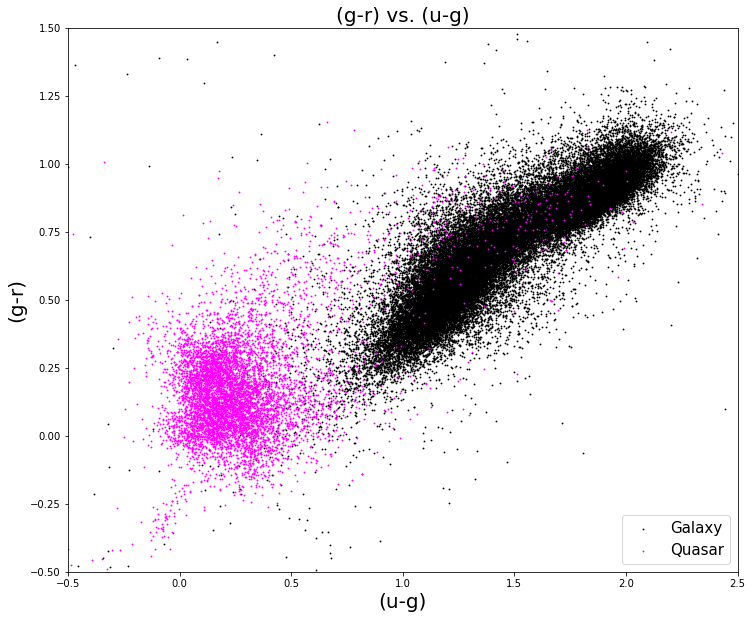

In [6]:
plt.figure(figsize=(12,10))
plt.scatter(ug[np.where(spec_arr=="GALAXY")], gr[np.where(spec_arr=="GALAXY")], color="black", label="Galaxy", s=0.7)
plt.scatter(ug[np.where(spec_arr=="QSO")], gr[np.where(spec_arr=="QSO")], color="magenta", label="Quasar", s=0.7)
plt.legend(fontsize=15)
plt.xlabel("(u-g)", fontsize=20)
plt.ylabel("(g-r)", fontsize=20)
plt.title("(g-r) vs. (u-g)", fontsize=20)
plt.xlim(-0.5, 2.5)
plt.ylim(-0.5, 1.5)
plt.show()

SRT: Nice!

3. Stack all colors and the redshift into a data matrix, $X$. Create a target label array that has $0$ for a regular galaxy and $1$ for a quasar. Perform a train-test split, taking $20\%$ of the data for testing.

In [7]:
X = np.vstack([ug, gr, ri, iz, rs_arr]).T
y = np.zeros(len(spec_arr))
y[np.where(spec_arr=="QSO")] = 1
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2)

4. Create a compact `for` loop that iterates over the fitting of a Gaussian Naive Bayes classification algorithm to successively more features of the data. Within the loop, compute and plot an ROC curve. The end result should be a plot showing ROC curves for GNB classification with more and more features of the data, with appropriate axis labels and a legend. Use `xlim` between 0 and 0.01. Which feature seems to make the classification trivially easy? *Note: `predict_proba` returns an array with as many columns as classes. You've labeled quasars as $1$, so for the ROC curve you must make sure to access the relevant quasar probability-- you can find this by accessing the **classes_** attribute of the estimator.*

MEK: Grab function from Lecture 19 and edit, print classes to know which column to grab (the 1st one), plot ROC curves for each iteration of adding an additional piece of information

Classes [0. 1.]
Classes [0. 1.]
Classes [0. 1.]
Classes [0. 1.]
Classes [0. 1.]


/home/kaldorme/miniconda3/envs/astro8070/lib/python3.10/site-packages/astroML/linear_model/linear_regression_errors.py:10: UserWarning: LinearRegressionwithErrors requires PyMC3 to be installed
  warnings.warn('LinearRegressionwithErrors requires PyMC3 to be installed')


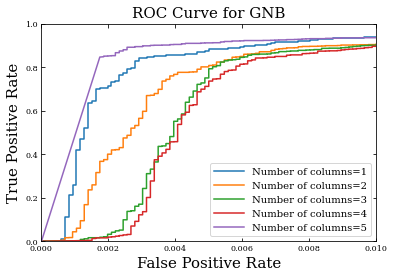

In [8]:
# Ivezic v2, Figure 9.3, edits by GTR and SRT
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)

classifiers = []
predictions = []

Ncolors = np.arange(1, X.shape[1] + 1)

for nc in Ncolors:
    clf = GaussianNB()
    clf.fit(Xtrain[:, :nc], ytrain)
    y_pred = clf.predict(Xtest[:, :nc])
    y_prob = []
    
    # Added by GTR to be able to compute precision, recall, fpr, and tpr
    # Gives the probability for both classes, take just one
    print("Classes", clf.classes_)
    y_prob = np.append(y_prob,clf.predict_proba(Xtest[:, :nc])[:,1])

    classifiers.append(clf)
    predictions.append(y_pred)
    
    fpr, tpr, thresh = roc_curve(ytest, y_prob)

    # add (0, 0) as first point
    fpr = np.concatenate([[0], fpr])
    tpr = np.concatenate([[0], tpr])

    plt.plot(fpr, tpr, label="Number of columns="+str(nc))

plt.title("ROC Curve for GNB", fontsize=15)
plt.xlabel("False Positive Rate", fontsize=15)
plt.ylabel("True Positive Rate", fontsize=15)
plt.legend(fontsize=10)
plt.xlim(0,0.01)
plt.show()

The 6th column (redshift) makes this easy! That makes sense, because we can see quasars out to much farther distances than regular galaxies.

5. Repeat (4) for Quadratic Discriminant Analysis. 

MEK: Repeat similar process with QDA

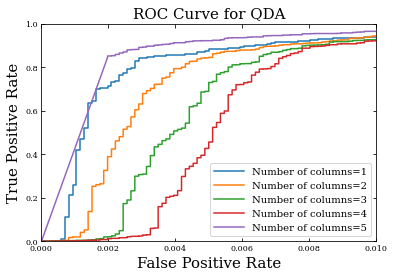

In [9]:
# Ivezic v2, Figure 9.3, edits by GTR and SRT
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)

classifiers = []
predictions = []
Ncolors = np.arange(1, X.shape[1] + 1)

y_prob = np.array([])

for nc in Ncolors:
    clf = QDA()
    clf.fit(Xtrain[:, :nc], ytrain)
    y_pred = clf.predict(Xtest[:, :nc])
    y_prob = []
    
    # Added by GTR to be able to compute precision, recall, fpr, and tpr
    # Gives the probability for both classes, take just one
    y_prob = np.append(y_prob,clf.predict_proba(Xtest[:, :nc])[:,1])

    classifiers.append(clf)
    predictions.append(y_pred)
    
    fpr, tpr, thresh = roc_curve(ytest, y_prob)

    # add (0, 0) as first point
    fpr = np.concatenate([[0], fpr])
    tpr = np.concatenate([[0], tpr])

    plt.plot(fpr, tpr, label="Number of columns="+str(nc))

plt.title("ROC Curve for QDA", fontsize=15)
plt.xlabel("False Positive Rate", fontsize=15)
plt.ylabel("True Positive Rate", fontsize=15)
plt.legend(fontsize=10)
plt.xlim(0,0.01)
plt.show()

6. Let's try classification with GMM Bayes. Restrict the training and testing to be just on the $4$ colors. Iterate now over number of components in the GMM Bayes fit up to $10$, plotting ROC curves for all, and find the number of components that gives the best performance.

MEK: Only use the 4 colors now, but use all colors every time (don't iterate over number of columns anymore), separate training and testing data

In [10]:
X = np.vstack([ug, gr, ri, iz]).T
y = np.zeros(len(spec_arr))
y[np.where(spec_arr=="QSO")] = 1
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2)

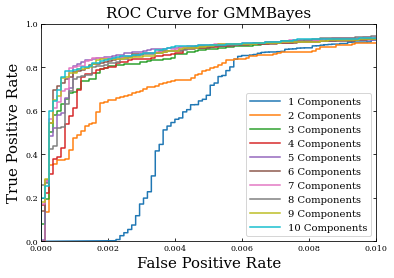

In [11]:
# From Lecture 19

# Ivezic v2, Figure 9.3, edits by GTR and SRT
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)

classifiers = []
predictions = []
areas = []
Ncolors = np.arange(1, X.shape[1] + 1)

y_prob = np.array([])
comps = np.arange(1,11,1)

for i in comps:
    clf = GMMBayes(i)
    clf.fit(Xtrain[:, :4], ytrain)
    y_pred = clf.predict(Xtest[:, :4])
    y_prob = []
        
    # Added by GTR to be able to compute precision, recall, fpr, and tpr
    # Gives the probability for both classes, take just one
    y_prob = np.append(y_prob,clf.predict_proba(Xtest[:, :4])[:,1])
    
    classifiers.append(clf)
    predictions.append(y_pred)
        
    fpr, tpr, thresh = roc_curve(ytest, y_prob)
    area = roc_auc_score(ytest, y_prob)
    areas.append(area)
    
    # add (0, 0) as first point
    fpr = np.concatenate([[0], fpr])
    tpr = np.concatenate([[0], tpr])
    
    plt.plot(fpr, tpr, label=str(i)+" Components")
    
plt.title("ROC Curve for GMMBayes", fontsize=15)
plt.xlabel("False Positive Rate", fontsize=15)
plt.ylabel("True Positive Rate", fontsize=15)
plt.legend(fontsize=10)
plt.xlim(0,0.01)
plt.show()

In [12]:
gmm_best = comps[np.where(areas == max(areas))][0]
print("Best number of components:", gmm_best)

Best number of components: 10


7. Repeat (6) for $K$-nearest neighbor classification, looping over number of neighbors between 5 and 100 in steps of 10. Find the number that gives the best performance. 

MEK: Repeat for KNN

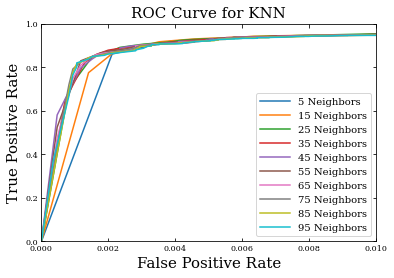

In [13]:
# Ivezic v2, Figure 9.3, edits by GTR and SRT
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)

classifiers = []
predictions = []
areas = []
Ncolors = np.arange(1, X.shape[1] + 1)

y_prob = np.array([])

neighbors = np.arange(5, 100, 10)

for i in neighbors:
    clf = KNeighborsClassifier(i)
    clf.fit(Xtrain[:, :4], ytrain)
    y_pred = clf.predict(Xtest[:, :4])
    y_prob = []
        
    # Added by GTR to be able to compute precision, recall, fpr, and tpr
    # Gives the probability for both classes, take just one
    y_prob = np.append(y_prob,clf.predict_proba(Xtest[:, :4])[:,1])
    
    classifiers.append(clf)
    predictions.append(y_pred)
        
    fpr, tpr, thresh = roc_curve(ytest, y_prob)
    area = roc_auc_score(ytest, y_prob)
    areas.append(area)
    
    # add (0, 0) as first point
    fpr = np.concatenate([[0], fpr])
    tpr = np.concatenate([[0], tpr])
    
    plt.plot(fpr, tpr, label=str(i)+" Neighbors")
    
plt.title("ROC Curve for KNN", fontsize=15)
plt.xlabel("False Positive Rate", fontsize=15)
plt.ylabel("True Positive Rate", fontsize=15)
plt.legend(fontsize=10)
plt.xlim(0,0.01)
plt.show()

In [14]:
knn_best = neighbors[np.where(areas == max(areas))][0]
print("Best number of neighbors:", knn_best)

Best number of neighbors: 65


8. Repeat (6) for Decision Tree classification, looping over the maximum tree depth between 1 and 10. Find the number that gives the best performance. 

MEK: Repeat for DT

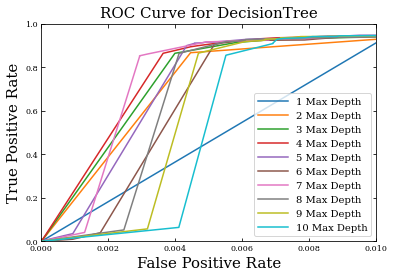

In [15]:
# Ivezic v2, Figure 9.3, edits by GTR and SRT
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)

classifiers = []
predictions = []
areas = []
Ncolors = np.arange(1, X.shape[1] + 1)

y_prob = np.array([])

for i in comps:
    clf = DecisionTreeClassifier(max_depth=i)
    clf.fit(Xtrain[:, :4], ytrain)
    y_pred = clf.predict(Xtest[:, :4])
    y_prob = []
        
    # Added by GTR to be able to compute precision, recall, fpr, and tpr
    # Gives the probability for both classes, take just one
    y_prob = np.append(y_prob,clf.predict_proba(Xtest[:, :4])[:,1])
    
    classifiers.append(clf)
    predictions.append(y_pred)
        
    fpr, tpr, thresh = roc_curve(ytest, y_prob)
    area = roc_auc_score(ytest, y_prob)
    areas.append(area)
    
    # add (0, 0) as first point
    fpr = np.concatenate([[0], fpr])
    tpr = np.concatenate([[0], tpr])
    
    plt.plot(fpr, tpr, label=str(i)+" Max Depth")
    
plt.title("ROC Curve for DecisionTree", fontsize=15)
plt.xlabel("False Positive Rate", fontsize=15)
plt.ylabel("True Positive Rate", fontsize=15)
plt.legend(fontsize=10)
plt.xlim(0,0.01)
plt.show()

In [16]:
dt_best = comps[np.where(areas == max(areas))][0]
print("Best number of components:", dt_best)

Best number of components: 6


9. Finally, plot the ROC curves for GNB, QDA, and the best-performing GMMBayes, KNN, and DT classification algorithms, all using just the 4 colors. What is the overall best-performing classifier?

MEK: Show the best options for each classified with respect to each other on the same plot

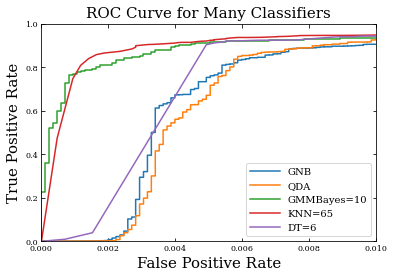

In [33]:
# Ivezic v2, Figure 9.3, edits by GTR and SRT
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)

classifiers = []
predictions = []
areas = []
Ncolors = np.arange(1, X.shape[1] + 1)
y_prob = np.array([])
clf = GaussianNB()
clf.fit(Xtrain[:, :4], ytrain)
y_pred = clf.predict(Xtest[:, :4])
y_prob = np.append(y_prob,clf.predict_proba(Xtest[:, :4])[:,1])
classifiers.append(clf)
predictions.append(y_pred)
fpr, tpr, thresh = roc_curve(ytest, y_prob)
area = roc_auc_score(ytest, y_prob)
areas.append(area)
fpr = np.concatenate([[0], fpr])
tpr = np.concatenate([[0], tpr])
plt.plot(fpr, tpr, label="GNB")

predictions = []
Ncolors = np.arange(1, X.shape[1] + 1)
y_prob = np.array([])
clf = QDA()
clf.fit(Xtrain[:, :4], ytrain)
y_pred = clf.predict(Xtest[:, :4])
y_prob = np.append(y_prob,clf.predict_proba(Xtest[:, :4])[:,1])
classifiers.append(clf)
predictions.append(y_pred)
fpr, tpr, thresh = roc_curve(ytest, y_prob)
area = roc_auc_score(ytest, y_prob)
areas.append(area)
fpr = np.concatenate([[0], fpr])
tpr = np.concatenate([[0], tpr])
plt.plot(fpr, tpr, label="QDA")

predictions = []
Ncolors = np.arange(1, X.shape[1] + 1)
y_prob = np.array([])
clf = GMMBayes(10)
clf.fit(Xtrain[:, :4], ytrain)
y_pred = clf.predict(Xtest[:, :4])
y_prob = np.append(y_prob,clf.predict_proba(Xtest[:, :4])[:,1])
classifiers.append(clf)
predictions.append(y_pred)
fpr, tpr, thresh = roc_curve(ytest, y_prob)
area = roc_auc_score(ytest, y_prob)
areas.append(area)
fpr = np.concatenate([[0], fpr])
tpr = np.concatenate([[0], tpr])
plt.plot(fpr, tpr, label="GMMBayes=10")

predictions = []
Ncolors = np.arange(1, X.shape[1] + 1)
y_prob = np.array([])
clf = KNeighborsClassifier(65)
clf.fit(Xtrain[:, :4], ytrain)
y_pred = clf.predict(Xtest[:, :4])
y_prob = np.append(y_prob,clf.predict_proba(Xtest[:, :4])[:,1])
classifiers.append(clf)
predictions.append(y_pred)
fpr, tpr, thresh = roc_curve(ytest, y_prob)
area = roc_auc_score(ytest, y_prob)
areas.append(area)
fpr = np.concatenate([[0], fpr])
tpr = np.concatenate([[0], tpr])
plt.plot(fpr, tpr, label="KNN=65")

predictions = []
Ncolors = np.arange(1, X.shape[1] + 1)
y_prob = np.array([])
clf = DecisionTreeClassifier(max_depth=6)
clf.fit(Xtrain[:, :4], ytrain)
y_pred = clf.predict(Xtest[:, :4])
y_prob = np.append(y_prob,clf.predict_proba(Xtest[:, :4])[:,1])
classifiers.append(clf)
predictions.append(y_pred)
fpr, tpr, thresh = roc_curve(ytest, y_prob)
area = roc_auc_score(ytest, y_prob)
areas.append(area)
fpr = np.concatenate([[0], fpr])
tpr = np.concatenate([[0], tpr])
plt.plot(fpr, tpr, label="DT=6")
    
plt.title("ROC Curve for Many Classifiers", fontsize=15)
plt.xlabel("False Positive Rate", fontsize=15)
plt.ylabel("True Positive Rate", fontsize=15)
plt.legend(fontsize=10)
plt.xlim(0,0.01)
plt.show()

In [34]:
print("Best classifier:", classifiers[np.where(areas==max(areas))[0][0]])

Best classifier: GMMBayes(n_components=array([10]))


MEK: GMMBayes with 10 components seems to be the best!

10. Make a 2-panel plot, showing in the left panel the color-coded training data in $(u-g)$ versus $(g-r)$ (similar to item 2 above), and in the right panel the same features of the testing data color coded by their predicted class from the tuned best-performing classifier. 

MEK: Fit with GMMB=10 as the best classifier

In [35]:
clf = GMMBayes(10)
clf.fit(Xtrain, ytrain)
y_pred = clf.predict(Xtest)

MEK: Plot the colors of the training data with true labels and the testing data with predicted labels. Not too bad!

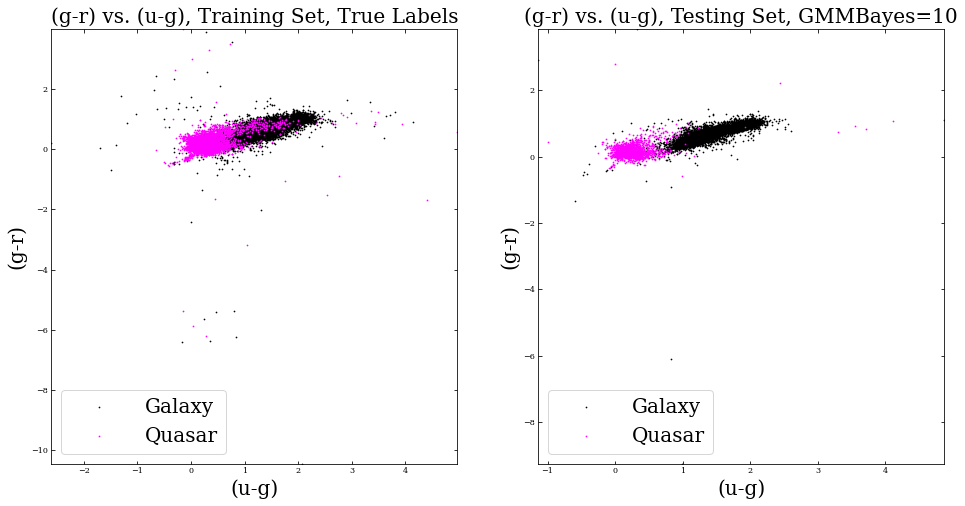

In [39]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,8))
ax1.scatter(Xtrain[np.where(ytrain==0)][:,0], Xtrain[np.where(ytrain==0)][:,1], color="black", label="Galaxy", s=0.5)
ax1.scatter(Xtrain[np.where(ytrain==1)][:,0], Xtrain[np.where(ytrain==1)][:,1], color="magenta", label="Quasar", s=0.5)
ax2.scatter(Xtest[np.where(y_pred==0)][:,0], Xtest[np.where(y_pred==0)][:,1], color="black", label="Galaxy", s=0.5)
ax2.scatter(Xtest[np.where(y_pred==1)][:,0], Xtest[np.where(y_pred==1)][:,1], color="magenta", label="Quasar", s=0.5)
ax1.set_title("(g-r) vs. (u-g), Training Set, True Labels", fontsize=20)
ax1.set_xlabel("(u-g)", fontsize=20)
ax1.set_ylabel("(g-r)", fontsize=20)
ax2.set_title("(g-r) vs. (u-g), Testing Set, GMMBayes=10", fontsize=20)
ax2.set_xlabel("(u-g)", fontsize=20)
ax2.set_ylabel("(g-r)", fontsize=20)
ax1.legend(fontsize=20)
ax2.legend(fontsize=20)
plt.show()

SRT: Indeed! Looks great.

## Problem 2

The first few steps of this problem are the same as the previous problem.


1. Read in the same galaxy color data used above. Slice the data array to only take every other 10th row. From this reduced data volume, create arrays of $(u-g)$, $(g-r)$, $(r-i)$, and $(i-z)$ colors. Also create arrays of redshift and the spectral class. 

MEK: Read in data again, and remake the arrays (this doesn't need to be done, but gives me some peace of mind to make sure the array contains what I think it does).

In [21]:
u_arr = data['u']
g_arr = data['g']
r_arr = data['r']
i_arr = data['i']
z_arr = data['z']
spec_arr = data['specClass']
rs_arr = data['redshift']
rse_arr = data['redshift_err']

ug = u_arr-g_arr
gr = g_arr-r_arr
ri = r_arr-i_arr
iz = i_arr-z_arr

MEK: Grab every 10th item in the array, and make color arrays from them ("red" in the array names stands for "reduced" in size).

In [22]:
u_red = u_arr[::10]
g_red = g_arr[::10]
r_red = r_arr[::10]
i_red = i_arr[::10]
z_red = z_arr[::10]
spec_red = spec_arr[::10]
rs_red = rs_arr[::10]
rse_red = rse_arr[::10]

ug_red = u_red-g_red
gr_red = g_red-r_red
ri_red = r_red-i_red
iz_red = i_red-z_red

2. We're going to make classification pretty tough for our deep neural network. Make a scatter plot of $(r-i)$ versus $(i-z)$, color coding by galaxy or quasar class. Notice how much more difficult the visual discrimination is compared to $(u-g)$ versus $(g-r)$. The plot should include appropriate axis labels and a legend.

MEK: Plot colors of objects with points color-coded by whether they are a galaxy or a quasar

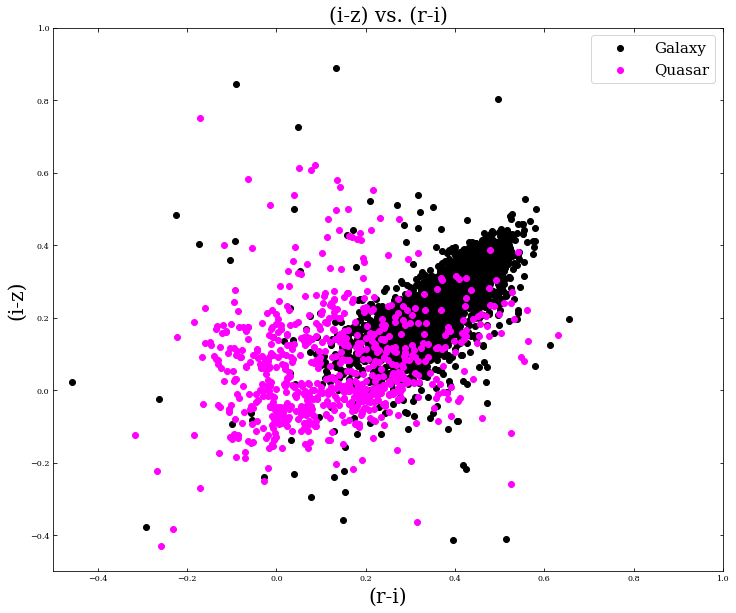

In [23]:
plt.figure(figsize=(12,10))
plt.scatter(ri_red[np.where(spec_red=="GALAXY")], iz_red[np.where(spec_red=="GALAXY")], color="black", label="Galaxy")
plt.scatter(ri_red[np.where(spec_red=="QSO")], iz_red[np.where(spec_red=="QSO")], color="magenta", label="Quasar")
plt.legend(fontsize=15)
plt.xlabel("(r-i)", fontsize=20)
plt.ylabel("(i-z)", fontsize=20)
plt.title("(i-z) vs. (r-i)", fontsize=20)
plt.xlim(-0.5, 1.0)
plt.ylim(-0.5, 1.0)
plt.show()

3. Stack the $(r-i)$ and $(i-z)$ colors into a data matrix, $X$. Create a target label array that has $0$ for a regular galaxy and $1$ for a quasar. Perform a train-test split, taking $20\%$ of the data for testing. Set the `random_state` in your train-test split to be `42` for reproducibility (and easy comparison with my solutions).

MEK: Stack colors into columns, make labels, and split testing and training data

In [24]:
X_red = np.vstack([ri_red, iz_red]).T
y_red = np.zeros(len(spec_red))
y_red[np.where(spec_red=="QSO")] = 1
Xtrain_red, Xtest_red, ytrain_red, ytest_red = train_test_split(X_red, y_red, test_size=0.2, random_state=42)

4. Scale your training and testing data to prepare it for the DNN. 

MEK: Steal function from SRT Lecture 22 (with minor edits) to normalize data - do this on training and testing data

In [25]:
def norm(array):
    datanormed = np.zeros((len(array), 2), dtype=np.float32)
    for i in range (0,2):
        datanormed[:, i] = ((array[:,i] - array[:,i].mean()) / array[:,i].std())
    return datanormed

Xtrain_norm = norm(Xtrain_red)
Xtest_norm = norm(Xtest_red)

5. Train scikit-learn's multi-layer perceptron classifier with ReLU activation, stochastic gradient descent, two hidden layers of respective sizes of $5$ and $2$, and using `max_iter=1000`, and `random_state=42`. As with classifiers in last week's homework, plot an ROC curve that shows the network's performance on the scaled testing data. 

MEK: Initialize classifier

In [26]:
clf = mlp(activation='relu', solver='sgd', hidden_layer_sizes=[5,2], max_iter=1000, random_state=42)

MEK: Train on training data

In [27]:
clf.fit(Xtrain_norm, ytrain_red)

MLPClassifier(hidden_layer_sizes=[5, 2], max_iter=1000, random_state=42,
              solver='sgd')

MEK: Predict on the testing data and plot ROC curve

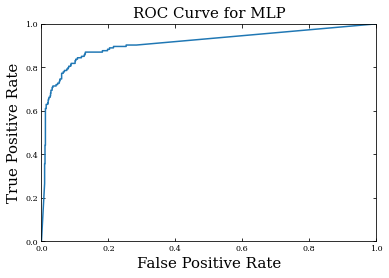

In [28]:
y_pred = clf.predict_proba(Xtest_norm)[:,1]

fpr, tpr, thresh = roc_curve(ytest_red, y_pred)
    
# add (0, 0) as first point
fpr = np.concatenate([[0], fpr])
tpr = np.concatenate([[0], tpr])
    
plt.plot(fpr, tpr)
plt.title("ROC Curve for MLP", fontsize=15)
plt.xlabel("False Positive Rate", fontsize=15)
plt.ylabel("True Positive Rate", fontsize=15)
plt.show()

6. Now let's optimize the hyperparameters of your network. You will use `GridSearchCV` with the following hyperparameters for the network:

```
parameters = {'solver': ['lbfgs', 'sgd', 'adam'], 
              'hidden_layer_sizes': [(2,2), (5,5), (5,2), (5,5,5)], 
              'activation': ['relu', 'tanh'], 
              'random_state': [42], 'max_iter': [1000]}
```

Remember that you can utilize all availables cores on your machine with `n_jobs=-1`. Print out the classification score for the training data, and the best parameters obtained by the cross validation.

MEK: Define parameters, initialize classifier, train on training data

In [29]:
parameters = {'solver': ['lbfgs', 'sgd', 'adam'], 
              'hidden_layer_sizes': [(2,2), (5,5), (5,2), (5,5,5)], 
              'activation': ['relu', 'tanh'], 
              'random_state': [42], 'max_iter': [1000]}

clf = GridSearchCV(mlp(), parameters, n_jobs=-1)
clf.fit(Xtrain_norm, ytrain_red)

/home/kaldorme/miniconda3/envs/astro8070/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/kaldorme/miniconda3/envs/astro8070/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/kaldorme/miniconda3/envs/astro8070/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfg

GridSearchCV(estimator=MLPClassifier(), n_jobs=-1,
             param_grid={'activation': ['relu', 'tanh'],
                         'hidden_layer_sizes': [(2, 2), (5, 5), (5, 2),
                                                (5, 5, 5)],
                         'max_iter': [1000], 'random_state': [42],
                         'solver': ['lbfgs', 'sgd', 'adam']})

MEK: Print out best score and best parameters used to get that score

In [30]:
best_score = clf.best_score_
best_params = clf.best_params_
print(best_score)
print(best_params)

0.93675
{'activation': 'relu', 'hidden_layer_sizes': (5, 5, 5), 'max_iter': 1000, 'random_state': 42, 'solver': 'lbfgs'}


7. Fit a new DNN using the best hyperparameters obtained in (6), and make a plot that has ROC curves for this new network and your original network. Let the x and y axes have the full limit range of 0 to 1. Voila!

MEK: Use the best parameters to train again!

In [31]:
clf = mlp(activation = best_params['activation'], hidden_layer_sizes=best_params['hidden_layer_sizes'], max_iter=best_params['max_iter'], random_state=best_params['random_state'],
         solver=best_params['solver'])
clf.fit(Xtrain_norm, ytrain_red)

MLPClassifier(hidden_layer_sizes=(5, 5, 5), max_iter=1000, random_state=42,
              solver='lbfgs')

MEK: Predict on the testing data and plot ROC curve

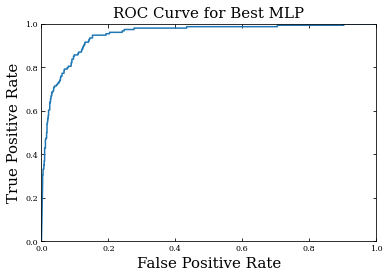

In [32]:
y_pred_best = clf.predict_proba(Xtest_norm)[:,1]

fpr, tpr, thresh = roc_curve(ytest_red, y_pred_best)
    
# add (0, 0) as first point
fpr = np.concatenate([[0], fpr])
tpr = np.concatenate([[0], tpr])
    
plt.plot(fpr, tpr)
plt.title("ROC Curve for Best MLP", fontsize=15)
plt.xlabel("False Positive Rate", fontsize=15)
plt.ylabel("True Positive Rate", fontsize=15)
plt.show()

MEK: It looks better than before! Nice!

SRT: Great job, Mary!

50/50